In [1]:
!pwd
%config IPCompleter.greedy=True # コードを自動補完
import sys
sys.executable

/yokoi.shingo/my_task/Bike_Shareing/InClass_work/run_pycaret


'/usr/local/bin/python3.7'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm_notebook as tqdm

import pycaret

# PyCaretで回帰モデル作成する

<br>

### PyCaret
- scikit-learn、XGBoost、Microsoft LightGBM、spaCyなど、いくつかの機械学習ライブラリとフレームワークのPythonラッパー
- 欠損値の補完、カテゴリカルデータの変換、機能エンジニアリング、さらにはハイパーパラメータの調整など、すべてを自動化する
- 参考: https://towardsdatascience.com/announcing-pycaret-an-open-source-low-code-machine-learning-library-in-python-4a1f1aad8d46

<br>

### 回帰のチュートリアルは下記
- https://github.com/pycaret/pycaret/blob/master/Tutorials/Regression%20Tutorial%20Level%20Beginner%20-%20REG101.ipynb

In [3]:
data_dir = "../input/add_feature_v8_InClass"
output_dir = "model/pycaret_regression/registered"
os.makedirs(output_dir, exist_ok=True)

df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'),
                       #dtype={'season': 'category',
                       #       'holiday': 'category',
                       #       'workingday': 'category',
                       #       'weather': 'category', 
                       #       'windspeed_category': 'category'},
                       parse_dates=['datetime'])
df_train = df_train.drop(['casual', 'registered'], axis=1)  # train setにしかない説明変数 削除
df_test = pd.read_csv(os.path.join(data_dir, 'test.csv'),
                      #dtype={'season': 'category',
                      #       'holiday': 'category',
                      #       'workingday': 'category',
                      #       'weather': 'category', 
                      #       'windspeed_category': 'category'},
                      parse_dates=['datetime'])

print(df_train.info())
display(df_train.head().style.background_gradient(cmap='Pastel1'))  # style.background_gradient でデータフレームに色付ける
display(df_train.describe().style.background_gradient(cmap='Pastel1'))

print(df_test.info())
display(df_test.head().style.background_gradient(cmap='Pastel1'))
display(df_test.describe().style.background_gradient(cmap='Pastel1'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13003 entries, 0 to 13002
Columns: 133 entries, datetime to count
dtypes: datetime64[ns](1), float64(85), int64(47)
memory usage: 13.2 MB
None


,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual_log,registered_log,count_log,dayofweek,year_season,hour_workingday_casual,hour_workingday_holiday_casual_v1,hour_workingday_holiday_casual_v2,hour_workingday_registered_rush,hour_workingday_registered_semi,hour_workingday_registered,count_season,count_season_mid,count_cat_cols_mid,elapsed_day,am_pm,weather_am_pm,discomfort,next_holiday,seasonholiday_mul,seasonworkingday_mul,seasonweather_mul,seasondayofweek_mul,seasonhour_mul,seasontemp_mul,seasonatemp_mul,seasonhumidity_mul,seasonwindspeed_mul,seasoncount_season_mid_mul,seasoncount_cat_cols_mid_mul,seasonam_pm_mul,seasonweather_am_pm_mul,holidayworkingday_mul,holidayweather_mul,holidaydayofweek_mul,holidayhour_mul,holidaytemp_mul,holidayatemp_mul,holidayhumidity_mul,holidaywindspeed_mul,holidaycount_season_mid_mul,holidaycount_cat_cols_mid_mul,holidayam_pm_mul,holidayweather_am_pm_mul,workingdayweather_mul,workingdaydayofweek_mul,workingdayhour_mul,workingdaytemp_mul,workingdayatemp_mul,workingdayhumidity_mul,workingdaywindspeed_mul,workingdaycount_season_mid_mul,workingdaycount_cat_cols_mid_mul,workingdayam_pm_mul,workingdayweather_am_pm_mul,weatherdayofweek_mul,weatherhour_mul,weathertemp_mul,weatheratemp_mul,weatherhumidity_mul,weatherwindspeed_mul,weathercount_season_mid_mul,weathercount_cat_cols_mid_mul,weatheram_pm_mul,weatherweather_am_pm_mul,dayofweekhour_mul,dayofweektemp_mul,dayofweekatemp_mul,dayofweekhumidity_mul,dayofweekwindspeed_mul,dayofweekcount_season_mid_mul,dayofweekcount_cat_cols_mid_mul,dayofweekam_pm_mul,dayofweekweather_am_pm_mul,hourtemp_mul,houratemp_mul,hourhumidity_mul,hourwindspeed_mul,hourcount_season_mid_mul,hourcount_cat_cols_mid_mul,houram_pm_mul,hourweather_am_pm_mul,tempatemp_mul,temphumidity_mul,tempwindspeed_mul,tempcount_season_mid_mul,tempcount_cat_cols_mid_mul,tempam_pm_mul,tempweather_am_pm_mul,atemphumidity_mul,atempwindspeed_mul,atempcount_season_mid_mul,atempcount_cat_cols_mid_mul,atempam_pm_mul,atempweather_am_pm_mul,humiditywindspeed_mul,humiditycount_season_mid_mul,humiditycount_cat_cols_mid_mul,humidityam_pm_mul,humidityweather_am_pm_mul,windspeedcount_season_mid_mul,windspeedcount_cat_cols_mid_mul,windspeedam_pm_mul,windspeedweather_am_pm_mul,count_season_midcount_cat_cols_mid_mul,count_season_midam_pm_mul,count_season_midweather_am_pm_mul,count_cat_cols_midam_pm_mul,count_cat_cols_midweather_am_pm_mul,am_pmweather_am_pm_mul,season_te,holiday_te,workingday_te,weather_te,year_te,month_te,day_te,dayofweek_te,hour_te,count
0,2011-01-01 00:00:00,2011,1,1,0,1,0,0,1,0.240000,0.287900,0.810000,0.000000,1.386294,2.639057,2.833213,5,2011.100000,0,0,0,0,0,0,56.000000,77,71.000000,0,0,1.076923,46.380495,0,0,0,1,5,0,0.240000,0.287900,0.810000,0.000000,77,71.000000,0,1.076923,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,5,0,0.240000,0.287900,0.810000,0.000000,77,71.000000,0,1.076923,0,1.200000,1.439500,4.050000,0.000000,385,355.000000,0,5.384615,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0.069096,0.194400,0.000000,18.480000,17.040000,0.000000,0.258462,0.233199,0.000000,22.168300,20.440900,0.000000,0.310046,0.000000,62.370000,57.510000,0.000000,0.872308,0.000000,0.000000,0.000000,0.000000,5467.000000,0,82.923077,0.000000,76.461538,0.000000,113.679457,169.524678,163.541173,185.194682,144.940338,96.062095,153.917431,170.880799,46.708861,16.000000
1,2011-01-01 01:00:00,2011,1,1,1,1,0,0,1,0.220000,0.272700,0.800000,0.000000,2.197225,3.496508,3.713572,5,2011.100000,0,0,0,0,0,0,56.000000,77,71.000000,0,0,1.076923,46.365542,0,0,0,1,5,1,0.220000,0.272700,0.800000,0.000000,77,71.000000,0,1.076923,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,5,1,0.220000,0.272700,0.800000,0.000000,77,71.000000,0,1.076923,5,1.100000,1.363500,4.000000,0.000000,385,355.000000,0,5.384615,0.2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4376 entries, 0 to 4375
Columns: 132 entries, datetime to hour_te
dtypes: datetime64[ns](1), float64(84), int64(47)
memory usage: 4.4 MB
None


/usr/local/lib/python3.7/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,datetime,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual_log,registered_log,count_log,dayofweek,year_season,hour_workingday_casual,hour_workingday_holiday_casual_v1,hour_workingday_holiday_casual_v2,hour_workingday_registered_rush,hour_workingday_registered_semi,hour_workingday_registered,count_season,count_season_mid,count_cat_cols_mid,elapsed_day,am_pm,weather_am_pm,discomfort,next_holiday,seasonholiday_mul,seasonworkingday_mul,seasonweather_mul,seasondayofweek_mul,seasonhour_mul,seasontemp_mul,seasonatemp_mul,seasonhumidity_mul,seasonwindspeed_mul,seasoncount_season_mid_mul,seasoncount_cat_cols_mid_mul,seasonam_pm_mul,seasonweather_am_pm_mul,holidayworkingday_mul,holidayweather_mul,holidaydayofweek_mul,holidayhour_mul,holidaytemp_mul,holidayatemp_mul,holidayhumidity_mul,holidaywindspeed_mul,holidaycount_season_mid_mul,holidaycount_cat_cols_mid_mul,holidayam_pm_mul,holidayweather_am_pm_mul,workingdayweather_mul,workingdaydayofweek_mul,workingdayhour_mul,workingdaytemp_mul,workingdayatemp_mul,workingdayhumidity_mul,workingdaywindspeed_mul,workingdaycount_season_mid_mul,workingdaycount_cat_cols_mid_mul,workingdayam_pm_mul,workingdayweather_am_pm_mul,weatherdayofweek_mul,weatherhour_mul,weathertemp_mul,weatheratemp_mul,weatherhumidity_mul,weatherwindspeed_mul,weathercount_season_mid_mul,weathercount_cat_cols_mid_mul,weatheram_pm_mul,weatherweather_am_pm_mul,dayofweekhour_mul,dayofweektemp_mul,dayofweekatemp_mul,dayofweekhumidity_mul,dayofweekwindspeed_mul,dayofweekcount_season_mid_mul,dayofweekcount_cat_cols_mid_mul,dayofweekam_pm_mul,dayofweekweather_am_pm_mul,hourtemp_mul,houratemp_mul,hourhumidity_mul,hourwindspeed_mul,hourcount_season_mid_mul,hourcount_cat_cols_mid_mul,houram_pm_mul,hourweather_am_pm_mul,tempatemp_mul,temphumidity_mul,tempwindspeed_mul,tempcount_season_mid_mul,tempcount_cat_cols_mid_mul,tempam_pm_mul,tempweather_am_pm_mul,atemphumidity_mul,atempwindspeed_mul,atempcount_season_mid_mul,atempcount_cat_cols_mid_mul,atempam_pm_mul,atempweather_am_pm_mul,humiditywindspeed_mul,humiditycount_season_mid_mul,humiditycount_cat_cols_mid_mul,humidityam_pm_mul,humidityweather_am_pm_mul,windspeedcount_season_mid_mul,windspeedcount_cat_cols_mid_mul,windspeedam_pm_mul,windspeedweather_am_pm_mul,count_season_midcount_cat_cols_mid_mul,count_season_midam_pm_mul,count_season_midweather_am_pm_mul,count_cat_cols_midam_pm_mul,count_cat_cols_midweather_am_pm_mul,am_pmweather_am_pm_mul,season_te,holiday_te,workingday_te,weather_te,year_te,month_te,day_te,dayofweek_te,hour_te
0,2012-07-01 00:00:00,2012,7,1,0,3,0,0,1,0.760000,0.727300,0.660000,0.000000,nan,nan,nan,6,2012.300000,0,0,0,0,0,0,237.500000,169,207.000000,547,0,1.000000,46.826186,0,0,0,3,18,0,2.280000,2.181900,1.980000,0.000000,507,621.000000,0,3.000000,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,6,0,0.760000,0.727300,0.660000,0.000000,169,207.000000,0,1.000000,0,4.560000,4.363800,3.960000,0.000000,1014,1242.000000,0,6.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0.552748,0.501600,0.000000,128.440000,157.320000,0.000000,0.760000,0.480018,0.000000,122.913700,150.551100,0.000000,0.727300,0.000000,111.540000,136.620000,0.000000,0.660000,0.000000,0.000000,0.000000,0.000000,34983.000000,0,169.000000,0.000000,207.000000,0.000000,195.690323,168.509015,163.556477,183.441885,215.161771,189.974462,154.259861,161.854369,47.200737
1,2012-07-01 01:00:00,2012,7,1,1,3,0,0,1,0.740000,0.697000,0.700000,0.134300,nan,nan,nan,6,2012.300000,0,0,0,0,0,0,237.500000,169,207.000000,547,0,1.000000,46.804428,0,0,0,3,18,3,2.220000,2.091000,2.100000,0.402900,507,621.000000,0,3.000000,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,0,0,0,0.000000,0.000000,0.000000,0.000000,0,0.000000,0,0.000000,6,1,0.740000,0.697000,0.700000,0.134300,169,207.000000,0,1.000000,6,4.440000,4.182000,4.200000,0.805800,1014,1242.000000,0,6.000000,0.740000,0.6970

In [4]:
# 列削除
_features =  ["registered_log", 
              "datetime",
              "temp", "atemp", "humidity", "windspeed", "count_season_mid", 
              "season", "holiday", "workingday", "weather", "year", "dayofweek", "hour", "hour_workingday_registered", "hour_workingday_registered_semi", "hour_workingday_registered_rush"]   
df_train = df_train[_features]

_features.remove("registered_log")
df_test = df_test[_features]

print(df_train.shape, df_test.shape)
print(df_train.info())
print(df_test.info())

(13003, 17) (4376, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13003 entries, 0 to 13002
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   registered_log                   13003 non-null  float64       
 1   datetime                         13003 non-null  datetime64[ns]
 2   temp                             13003 non-null  float64       
 3   atemp                            13003 non-null  float64       
 4   humidity                         13003 non-null  float64       
 5   windspeed                        13003 non-null  float64       
 6   count_season_mid                 13003 non-null  int64         
 7   season                           13003 non-null  int64         
 8   holiday                          13003 non-null  int64         
 9   workingday                       13003 non-null  int64         
 10  weather                          13

## 1. 必要なモジュールをインポート + setup(trainデータ, target=目的変数の列名) でデータ前処理
- setup(trainデータ, target=目的変数の列名)で以下の前処理を自動的に実行
    - 欠損値代入（デフォルトは平均値が入る）
    - データ型の変更
    - categorical encoding（カテゴリ列は、yesまたはnoを1または0に変換（onehot化）して、ダミー化（列増やす））
    - train-test-split（デフォルトでは train:test=7:3 に分ける）

<br>
    
- setup()の引数で、前処理パイプラインカスタマイズできる。デフォルトでは正規化（Normalize）とかは実行されない
- setup()を実行すると、各フィールドが数値列なのか、カテゴリ列なのかを自動判別し、結果の一覧表が表示される。

<br>

## <span style="color: red; ">相違がなければリターンキーを実行する</span>。実行すると必要な前処理を実施され、結果の一覧表が表示される

In [5]:
from pycaret.regression import *  
# 分類の場合は from pycaret.classification import *

In [6]:
#help(setup)

In [7]:
_session_id = 123
_target = "registered_log"
_silent = True
#_date_features = ["datetime"] 
_ignore_features = ["datetime"] 
model_name = 'lightgbm'

# exp は (x, y, train_x, val_x, train_y, val_y, session_id, sklearn_pipeline)のタプル
exp = setup(df_train,
            session_id=_session_id,
            target=_target,
            silent=_silent,  # 「silent=True」を渡すことで、型推定の確認でenter押すのスキップ,
            #date_features=_date_features,
            #categorical_features=_categorical_features, 
            #numeric_features=_numeric_features,
            ignore_features = _ignore_features,
            #bin_numeric_features=["windspeed"],  # ビン化したい数値データ特徴量のカラム名をリストで指定
            #normalize=True,  # 各numeric_featuresを正規化
            #normalize_method='zscore',  # 正規化の方法は標準化
            #normalize_method='minmax',  # Min-Maxスケーリング
            #remove_outliers=True,  # PCAを使用して外れ値除去
            #outliers_threshold=0.05,  # 外れ値の割合を指定。デフォルトの0.05を指定すると、分布の裾の両側の値の0.025%が除去
            #ignore_low_variance=True,  # 統計的に有意ではない分散を持つ特徴量を削除
            #polynomial_features=True,  # 全ての数値データ特徴量の多項式の組み合わせで新たな特徴量を生成
            #polynomial_degree=2,  # 多項式特徴の次数を指定。default = 2
           )

# 常に全ての列（カラム）を表示
pd.set_option('display.max_columns', None)
display(exp[0].head(3))
pd.concat([exp[0], exp[1]], axis=1).to_csv(os.path.join(output_dir, 'train_setup.csv'), index=False)  # 一応前処理後のtrain set保存しておく

print(exp[0].shape)
print(exp[1][:5])
print(exp[1].apply(np.expm1)[:5])  # np.log1pの逆変換

 
Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(13003, 17)"
4,Missing Values,False
5,Numeric Features,5
6,Categorical Features,9
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


,temp,atemp,humidity,windspeed,hour,count_season_mid_127,count_season_mid_165,season_1,season_3,holiday_0,workingday_0,weather_1,weather_2,weather_3,weather_4,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_workingday_registered_0,hour_workingday_registered_semi_1,hour_workingday_registered_rush_1,year_month_1,year_weekday_5,year_is_month_end_0,year_is_month_start_1
0,0.24,0.2879,0.81,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1,0.22,0.2727,0.80,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2,0.22,0.2727,0.80,0.0,2.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0


(13003, 29)
0    2.639057
1    3.496508
2    3.332205
3    2.397895
4    0.693147
Name: registered_log, dtype: float64
0    13.0
1    32.0
2    27.0
3    10.0
4     1.0
Name: registered_log, dtype: float64


In [8]:
model = create_model(model_name)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2167,0.0997,0.3157,0.9481,0.0924,0.0846
1,0.2231,0.1014,0.3184,0.9496,0.0919,0.0829
2,0.2186,0.0934,0.3055,0.9521,0.0860,0.0758
3,0.2105,0.0910,0.3017,0.9528,0.0886,0.0731
4,0.2260,0.1138,0.3373,0.9371,0.0954,0.0813
5,0.2032,0.0886,0.2977,0.9533,0.0880,0.0754
6,0.2220,0.1121,0.3348,0.9477,0.1061,0.0857
7,0.2166,0.0986,0.3140,0.9448,0.0858,0.0719
8,0.2080,0.0902,0.3004,0.9504,0.0858,0.0742
9,0.2099,0.0917,0.3028,0.9534,0.0899,0.0705


In [9]:
display(predict_model(model, data=df_train).head(15))

,registered_log,datetime,temp,atemp,humidity,windspeed,count_season_mid,season,holiday,workingday,weather,year,dayofweek,hour,hour_workingday_registered,hour_workingday_registered_semi,hour_workingday_registered_rush,Label
0,2.639057,2011-01-01 00:00:00,0.24,0.2879,0.81,0.0000,77,1,0,0,1,2011,5,0,0,0,0,4.0708
1,3.496508,2011-01-01 01:00:00,0.22,0.2727,0.80,0.0000,77,1,0,0,1,2011,5,1,0,0,0,3.8833
2,3.332205,2011-01-01 02:00:00,0.22,0.2727,0.80,0.0000,77,1,0,0,1,2011,5,2,0,0,0,3.4500
3,2.397895,2011-01-01 03:00:00,0.24,0.2879,0.75,0.0000,77,1,0,0,1,2011,5,3,0,0,0,2.6734
4,0.693147,2011-01-01 04:00:00,0.24,0.2879,0.75,0.0000,77,1,0,0,1,2011,5,4,0,0,0,1.8153
5,0.693147,2011-01-01 05:00:00,0.24,0.2576,0.75,0.0896,77,1,0,0,2,2011,5,5,0,0,0,1.8754
6,0.000000,2011-01-01 06:00:00,0.22,0.2727,0.80,0.0000,77,1,0,0,1,2011,5,6,0,0,0,2.3236
7,1.098612,2011-01-01 07:00:00,0.20,0.2576,0.86,0.0000,77,1,0,0,1,2011,5,7,0,0,0,3.0513
8,2.079442,2011-01-01 08:00:00,0.24,0.2879,0.75,0.0000,77,1,0,0,1,2011,5,8,0,0,0,4.4227
9,1.945910,2011-01-01 09:00:00,0.32,0.3485,0.76,0.0000,77,1,0,0,1,2011,5,9,0,0,0,4.8673


In [10]:
display(predict_model(model, data=df_test).head(3))

,datetime,temp,atemp,humidity,windspeed,count_season_mid,season,holiday,workingday,weather,year,dayofweek,hour,hour_workingday_registered,hour_workingday_registered_semi,hour_workingday_registered_rush,Label
0,2012-07-01 00:00:00,0.76,0.7273,0.66,0.0000,169,3,0,0,1,2012,6,0,0,0,0,4.6377
1,2012-07-01 01:00:00,0.74,0.6970,0.70,0.1343,169,3,0,0,1,2012,6,1,0,0,0,4.4208
2,2012-07-01 02:00:00,0.72,0.6970,0.74,0.0896,169,3,0,0,1,2012,6,2,0,0,0,4.1398


In [11]:
create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.6671,0.7078,0.8413,0.6318,0.2179,0.2581
1,0.6854,0.7330,0.8561,0.6358,0.2253,0.2667
2,0.6890,0.7546,0.8687,0.6125,0.2247,0.2586
3,0.6799,0.7394,0.8599,0.6165,0.2261,0.2542
4,0.6895,0.7590,0.8712,0.5806,0.2232,0.2573
5,0.6677,0.7080,0.8414,0.6267,0.2198,0.2538
6,0.7026,0.8027,0.8959,0.6256,0.2435,0.2810
7,0.6774,0.7160,0.8462,0.5990,0.2113,0.2325
8,0.6643,0.6908,0.8311,0.6200,0.2123,0.2377
9,0.6790,0.7198,0.8484,0.6343,0.2255,0.2513


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 2.compare_models()で各種のモデルを評価、比較し誤差の少ない順番に並べる
- k分割交差検証（デフォルトでは10分割）を使用して一般的な評価指標を比較する（比較結果だけでモデル自体は返さない）
    - 回帰の評価指標： MAE、MSE、RMSE、R2、RMSLE、MAPE
    - 分類の評価指標：accuracy、AUC、recall、precision、F1、kappa
- 各指標で一番良い結果が黄色セルになる

In [12]:
#help(compare_models)

In [13]:
%%time

compare_models(sort='RMSLE',  # 結果をRMSLEでソートするようにする（デフォルトはMAE）
               fold=5  #  cvのfold数を5にする（デフォルトは10）。減らすことで処理時間短縮できる
              )

CPU times: user 2min 56s, sys: 6.1 s, total: 3min 2s
Wall time: 5min 32s


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.210100,0.094000,0.306400,0.951200,0.090100,0.076300
1,Light Gradient Boosting Machine,0.217500,0.100100,0.316200,0.948000,0.092000,0.078400
2,Random Forest,0.228200,0.112300,0.335000,0.941600,0.097400,0.083300
3,Extra Trees Regressor,0.230200,0.117300,0.342300,0.939100,0.100500,0.083900
4,Extreme Gradient Boosting,0.281700,0.150000,0.387300,0.922000,0.108800,0.101000
5,Gradient Boosting Regressor,0.281500,0.149400,0.386400,0.922400,0.108800,0.101200
6,K Neighbors Regressor,0.302800,0.176700,0.420200,0.908100,0.113800,0.104700
7,Decision Tree,0.314500,0.219300,0.468100,0.886000,0.134200,0.110900
8,AdaBoost Regressor,0.556100,0.451800,0.672100,0.765200,0.157400,0.164800
9,Support Vector Machine,0.426000,0.351100,0.592500,0.817600,0.166000,0.168700


## 3.実際に訓練されたモデルを利用するためにcreate_model('モデル名')でモデル作成
- compare_models()の結果を元に作りたいモデル指定する
- create_model()の引数に文字列入力として渡されるモデル名を渡せばいい
- Shift+Tabで引数に何を入れれば良いかのガイドが出る
- k分割交差検証スコアとトレーニング済みモデルオブジェクトを含むテーブルを返す

In [14]:
#help(create_model)

In [15]:
#catboost = create_model('catboost', fold=5  #  cvのfold数を5にする（デフォルトは10）。減らすことで処理時間短縮できる
#                       )
#lightgbm = create_model('lightgbm', fold=5  #  cvのfold数を5にする（デフォルトは10）。減らすことで処理時間短縮できる
#                       )
#et = create_model('et', fold=5  #  cvのfold数を5にする（デフォルトは10）。減らすことで処理時間短縮できる
#                 )
#rf = create_model('rf', fold=5  #  cvのfold数を5にする（デフォルトは10）。減らすことで処理時間短縮できる
#                 )
#print(catboost)
#print(lightgbm)
#print(et)
#print(rf)

## 4.tune_model('モデル名')で自動パラメータチューニング
- Random Searchでパラメータチューニング行う
- create_model('モデル名')の引数に文字列入力として渡されるモデル名を渡せばいい。モデルオブジェクトを渡すわけではないので注意
- k分割交差検証スコアとトレーニング済みモデルオブジェクトを含むテーブルを返す

In [16]:
#help(tune_model)

In [17]:
%%time

choice_ms = ['catboost', 'lightgbm']#, 'rf']
#choice_ms = ['br', 'lightgbm']  # お試し用
tune_models = []
for m in choice_ms:
    tuned_m = tune_model(m, 
                         fold=8,  #  cvのfold数を5にする（デフォルトは10）。減らすことで処理時間短縮できる
                         optimize='mse',  # optimizer指定できる。デフォルトはR2
                         n_iter=200,  # ランダムグリッド探索内での反復回数。デフォルトは10
                        )
    tune_models.append(tuned_m)

tuned_lightgbm = tune_models[1]
print(tune_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2100,0.0923,0.3037,0.9526,0.0891,0.0815
1,0.2177,0.0968,0.3112,0.9517,0.0871,0.0782
2,0.2094,0.0905,0.3007,0.9518,0.0888,0.0763
3,0.2184,0.1078,0.3283,0.9422,0.0951,0.0769
4,0.2012,0.0879,0.2965,0.9547,0.0859,0.0734
5,0.2133,0.1011,0.3179,0.9497,0.1013,0.0791
6,0.2073,0.0923,0.3038,0.9491,0.0856,0.0734
7,0.2056,0.0885,0.2976,0.9544,0.0872,0.0712
Mean,0.2103,0.0946,0.3075,0.9508,0.0900,0.0762
SD,0.0055,0.0064,0.0103,0.0037,0.0051,0.0032


[<catboost.core.CatBoostRegressor object at 0x7f36c8999a20>, LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=110,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
              n_estimators=200, n_jobs=-1, num_leaves=30, objective=None,
              random_state=123, reg_alpha=0.3, reg_lambda=0.7, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]
CPU times: user 19min 59s, sys: 5min 39s, total: 25min 39s
Wall time: 52min 4s


## 5.ビジュアライズ
- スタッキングなどのアンサンブルモデルでは可視化できないみたいなので注意

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


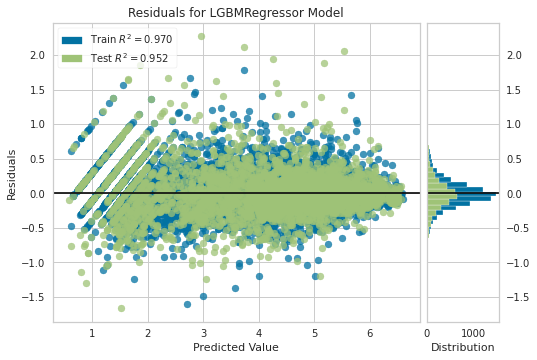

In [18]:
plot_model(tuned_lightgbm)

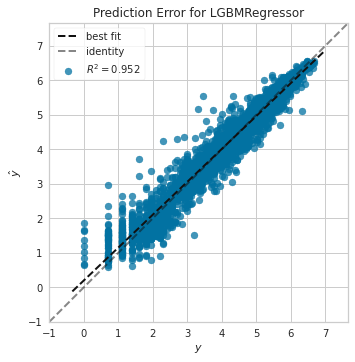

In [19]:
plot_model(tuned_lightgbm, plot='error')

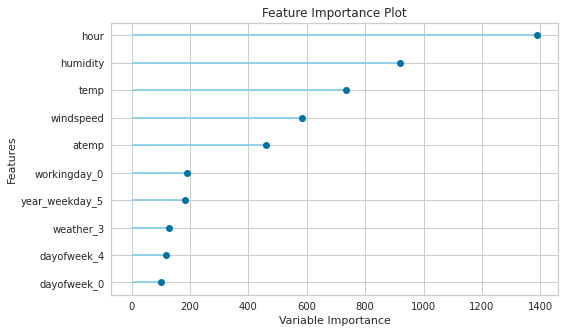

In [20]:
plot_model(tuned_lightgbm, plot='feature')

In [21]:
# 与えられたモデルで利用可能なすべてのプロットのユーザー・インターフェースをすべて表示
# Jupyter Labではevaluate_model()機能しないので注意
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## 6.SHAPでツリーベースのモデル解釈
- LIMEとSHAPは、機械学習モデルがあるサンプルの予測についてどのような根拠でその予測を行ったかを解釈する
- SHAPツールから得られる情報はLIMEと似たような感じで特定サンプルの予測における各特徴量の寄与スコア
- 決定木ベースのモデルでないとエラー
- スタッキングなどのアンサンブルモデルでは可視化できないみたいなので注意

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


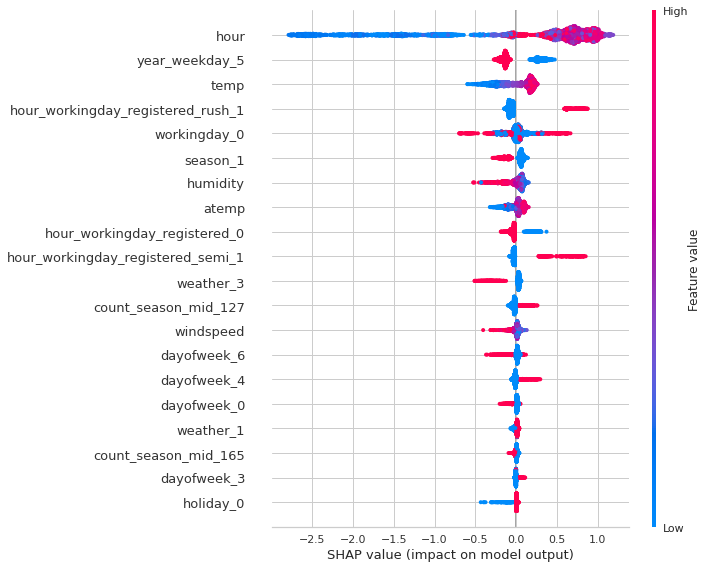

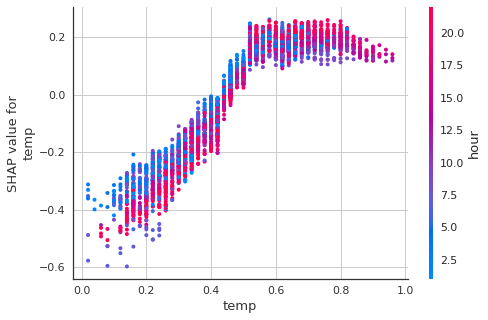

In [22]:
# summary plot
interpret_model(tuned_lightgbm)
# correlation plot
interpret_model(tuned_lightgbm, plot='correlation')

In [23]:
# テストデータセット内の特定のデータポイント（reason引数とも呼ばれる）の解釈は、
# 「reason」プロットを使用して評価できます。
# 以下の例では、テストデータセットの最初のインスタンスをチェックしています。
interpret_model(tuned_lightgbm, plot='reason', observation=0)  # observation=0 → validation setの1件目

In [24]:
interpret_model(tuned_lightgbm, plot='reason', observation=1)   # observation=1 → validation setの2件目

## 7.finalize_model()を実行し、モデルを確定
- finalize_model()関数は、完全なデータセットにモデルを適合させる（validation setなしってこと）
- この関数の目的は、本番で展開する前に、完全なデータセット上でモデルを訓練すること
- スタッキングなどのアンサンブルモデルでは可視化できないみたいなので注意

In [25]:
%%time

f_tune_models = []
for m, name in zip(tune_models, choice_ms):
    f_m = finalize_model(m)
    f_tune_models.append(f_m)
    save_model(f_m, model_name=os.path.join(output_dir, 'pycaret_tuned_' + name))

print(f_tune_models)

Transformation Pipeline and Model Succesfully Saved
[<catboost.core.CatBoostRegressor object at 0x7f36c8697588>, LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=110,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0,
              n_estimators=200, n_jobs=-1, num_leaves=30, objective=None,
              random_state=123, reg_alpha=0.3, reg_lambda=0.7, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)]
CPU times: user 8.28 s, sys: 1.96 s, total: 10.2 s
Wall time: 21.7 s


## 8.モデルのアンサンブルもできる

### blend_models()は複数のモデルの予測値を平均化して最終的な予測値を作成する
- メモリ足りないとjupyter落ちる

In [26]:
%%time

blend_specific = blend_models(f_tune_models)
# モデル保存
save_model(blend_specific, model_name=os.path.join(output_dir, 'pycaret_blend_specific'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1986,0.0896,0.2994,0.9534,0.0907,0.0796
1,0.2113,0.0924,0.3039,0.9541,0.0876,0.0792
2,0.2015,0.0818,0.2861,0.9580,0.0823,0.0717
3,0.1952,0.0817,0.2858,0.9576,0.0865,0.0695
4,0.2124,0.1033,0.3215,0.9429,0.0932,0.0779
5,0.1921,0.0797,0.2823,0.9580,0.0851,0.0727
6,0.2060,0.1015,0.3186,0.9526,0.1029,0.0810
7,0.1999,0.0843,0.2903,0.9528,0.0823,0.0682
8,0.1952,0.0809,0.2844,0.9555,0.0828,0.0713
9,0.1977,0.0809,0.2845,0.9589,0.0865,0.0678


Transformation Pipeline and Model Succesfully Saved
CPU times: user 1min 3s, sys: 13.1 s, total: 1min 17s
Wall time: 2min 44s


### stack_models()でスタッキング（モデルを積み重ねる）
- メモリ足りないとjupyter落ちる

In [27]:
#help(stack_models)

In [28]:
%%time

stack_1 = stack_models(estimator_list=f_tune_models, 
                       finalize=True,  # finalize_model()で学習。デフォルトはFalse
                      )
# モデル保存
save_model(stack_1, model_name=os.path.join(output_dir, 'pycaret_stack_1'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.2763,0.1470,0.3834,0.9071,0.1245,0.1182
1,0.4078,0.2732,0.5227,0.8464,0.1518,0.1544
2,0.3987,0.2290,0.4786,0.8689,0.1189,0.1090
3,0.1682,0.0622,0.2493,0.9619,0.0770,0.0514
4,0.2304,0.1229,0.3505,0.9296,0.1020,0.0747
5,0.2579,0.1554,0.3942,0.9115,0.0983,0.0898
6,0.3226,0.1899,0.4358,0.8966,0.1156,0.1123
7,0.2479,0.1158,0.3403,0.9431,0.0989,0.0987
8,0.2228,0.1041,0.3226,0.9484,0.0873,0.0738
9,0.1943,0.0804,0.2836,0.9546,0.0697,0.0573


Transformation Pipeline and Model Succesfully Saved
CPU times: user 1min 25s, sys: 20.3 s, total: 1min 45s
Wall time: 3min 35s


In [29]:
%%time

stack_meta = stack_models(estimator_list=f_tune_models[1:], 
                          meta_model=f_tune_models[0],  # 予測値を生成する最終モデル指定。デフォルトは線形回帰
                          finalize=True,  # finalize_model()で学習。デフォルトはFalse
                         )
# モデル保存
save_model(stack_meta, model_name=os.path.join(output_dir, 'pycaret_stack_meta'))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3385,0.2070,0.4550,0.8692,0.1406,0.1420
1,0.4830,0.3694,0.6078,0.7922,0.1692,0.1806
2,0.4153,0.2644,0.5142,0.8487,0.1239,0.1131
3,0.1877,0.0789,0.2809,0.9516,0.0846,0.0575
4,0.2570,0.1504,0.3878,0.9139,0.1117,0.0837
5,0.2725,0.1760,0.4196,0.8997,0.1044,0.0931
6,0.3771,0.2671,0.5168,0.8546,0.1333,0.1292
7,0.2955,0.1564,0.3954,0.9232,0.1078,0.1095
8,0.2863,0.1579,0.3974,0.9216,0.0992,0.0862
9,0.2257,0.1158,0.3402,0.9347,0.0867,0.0668


Transformation Pipeline and Model Succesfully Saved
CPU times: user 1min 43s, sys: 21.6 s, total: 2min 5s
Wall time: 3min 54s


## 9.モデルで予測

In [30]:
# predict_modelは実運用のtestセットで使われる
predictions = predict_model(tuned_lightgbm, data=df_test)

# 予測結果のLabel列とScore列ができる
display(predictions.head())

,datetime,temp,atemp,humidity,windspeed,count_season_mid,season,holiday,workingday,weather,year,dayofweek,hour,hour_workingday_registered,hour_workingday_registered_semi,hour_workingday_registered_rush,Label
0,2012-07-01 00:00:00,0.76,0.7273,0.66,0.0000,169,3,0,0,1,2012,6,0,0,0,0,4.5743
1,2012-07-01 01:00:00,0.74,0.6970,0.70,0.1343,169,3,0,0,1,2012,6,1,0,0,0,4.4685
2,2012-07-01 02:00:00,0.72,0.6970,0.74,0.0896,169,3,0,0,1,2012,6,2,0,0,0,4.3788
3,2012-07-01 03:00:00,0.72,0.7121,0.84,0.1343,169,3,0,0,1,2012,6,3,0,0,0,3.3913
4,2012-07-01 04:00:00,0.70,0.6667,0.79,0.1940,169,3,0,0,1,2012,6,4,0,0,0,2.1756


In [31]:
predictions = predict_model(stack_meta, data=df_test)
display(predictions.head())

,datetime,temp,atemp,humidity,windspeed,count_season_mid,season,holiday,workingday,weather,year,dayofweek,hour,hour_workingday_registered,hour_workingday_registered_semi,hour_workingday_registered_rush,Label
0,2012-07-01 00:00:00,0.76,0.7273,0.66,0.0000,169,3,0,0,1,2012,6,0,0,0,0,4.5864
1,2012-07-01 01:00:00,0.74,0.6970,0.70,0.1343,169,3,0,0,1,2012,6,1,0,0,0,4.4226
2,2012-07-01 02:00:00,0.72,0.6970,0.74,0.0896,169,3,0,0,1,2012,6,2,0,0,0,4.3045
3,2012-07-01 03:00:00,0.72,0.7121,0.84,0.1343,169,3,0,0,1,2012,6,3,0,0,0,3.4718
4,2012-07-01 04:00:00,0.70,0.6667,0.79,0.1940,169,3,0,0,1,2012,6,4,0,0,0,2.3344


## 10.モデルの保存/実験の保存

### モデルのデプロイ

In [32]:
## トレーニング済みモデルを含むパイプライン全体を、ノートブック環境からクラウドにデプロイできます
#deploy_model(model = rf, model_name = 'rf_aws', platform = 'aws', 
#             authentication =  {'bucket'  : 'pycaret-test'})

### モデルをpklファイルに保存
#### <span style="color: red; ">load_model()はsetup()実行してからでないとエラーになる</span>

In [33]:
# すべての前処理変換とトレーニング済みのモデルオブジェクトを含むパイプライン全体をバイナリpklファイルとして保存
# saving model(./ada_for_deployment.pklができる)

# load_modelでロードできる
model = load_model(os.path.join(output_dir, 'pycaret_tuned_lightgbm'))
predict_model(model, data=df_test)

,datetime,temp,atemp,humidity,windspeed,count_season_mid,season,holiday,workingday,weather,year,dayofweek,hour,hour_workingday_registered,hour_workingday_registered_semi,hour_workingday_registered_rush,Label
0,2012-07-01 00:00:00,0.76,0.7273,0.66,0.0000,169,3,0,0,1,2012,6,0,0,0,0,4.6653
1,2012-07-01 01:00:00,0.74,0.6970,0.70,0.1343,169,3,0,0,1,2012,6,1,0,0,0,4.5167
2,2012-07-01 02:00:00,0.72,0.6970,0.74,0.0896,169,3,0,0,1,2012,6,2,0,0,0,4.3023
3,2012-07-01 03:00:00,0.72,0.7121,0.84,0.1343,169,3,0,0,1,2012,6,3,0,0,0,3.4206
4,2012-07-01 04:00:00,0.70,0.6667,0.79,0.1940,169,3,0,0,1,2012,6,4,0,0,0,2.3344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4371,2012-12-31 19:00:00,0.26,0.2576,0.60,0.1642,77,1,0,1,2,2012,0,19,0,1,0,5.3893
4372,2012-12-31 20:00:00,0.26,0.2576,0.60,0.1642,77,1,0,1,2,2012,0,20,0,0,0,5.0311
4373,2012-12-31 21:00:00,0.26,0.2576,0.60,0.1642,77,1,0,1,1,2012,0,21,0,0,0,4.6957
4374,2012-12-31 22:00:00,0.26,0.2727,0.56,0.1343,77,1,0,1,1,2012,0,22,0,0,0,4.3723


### 構築したすべての出力とモデルを含む実験全体をpklファイルとして保存することもできる
#### <span style="color: red; ">load_experiment()はsetup()実行してからでないとエラーになる</span>

In [34]:
# ./my_first_experiment.pklができる
#save_experiment(os.path.join(output_dir, 'pycaret_my_first_experiment'))

In [35]:
# load_experimentでロードできる
# 実験全体とすべての中間出力が変数saved_experimentにロードされる
#saved_experiment = load_experiment(os.path.join(output_dir, 'pycaret_my_first_experiment'))

In [36]:
#loaded_model = saved_experiment[31]
#new_prediction = predict_model(loaded_model, 
#                               data=df_test, 
#                               round=1  # Label列の有効数字小数第2位までにする
#                              )
#new_prediction.head()

### submission.csv作成

In [37]:
def output_submit(model, submit_csv, data=df_test):
    """submission.csv作成"""
    print("data.shape:", data.shape)
    predictions = predict_model(model, data=data)
    
    # 対数化を戻す
    predictions["Label"] = predictions["Label"].apply(np.expm1)
    
    ## datetime列取り出す
    #df_test_orig = pd.read_csv(os.path.join(data_dir, 'test.csv'), parse_dates=['datetime'])
    
    #df_pred_submit = pd.concat([df_test_orig['datetime'], predictions['Label']], axis=1)
    df_pred_submit = predictions[['datetime', 'Label']].copy()
    df_pred_submit = df_pred_submit.rename(columns={'Label': 'cnt'})
    
    # inf対策
    df_pred_submit['cnt'] = df_pred_submit['cnt'].replace([np.inf, -np.inf], np.nan).fillna(0.0)
    
    df_pred_submit.loc[df_pred_submit['cnt'] < 0, 'cnt'] = 0  # マイナスの値は0にする
    df_pred_submit.to_csv(submit_csv, index=False)
    return df_pred_submit


if 'catboost' in choice_ms:
    loaded_model = load_model(os.path.join(output_dir, 'pycaret_tuned_catboost'))
    df_pred_submit = output_submit(loaded_model, os.path.join(output_dir, 'tuned_catboost.csv'))
    display(df_pred_submit)

if 'lightgbm' in choice_ms:
    loaded_model = load_model(os.path.join(output_dir, 'pycaret_tuned_lightgbm'))
    df_pred_submit = output_submit(loaded_model, os.path.join(output_dir, 'tuned_lightgbm.csv'))
    display(df_pred_submit)

loaded_model = load_model(os.path.join(output_dir, 'pycaret_blend_specific'))
df_pred_submit = output_submit(loaded_model, os.path.join(output_dir, 'blend.csv'))
display(df_pred_submit)

loaded_model = load_model(os.path.join(output_dir, 'pycaret_stack_1'))
df_pred_submit = output_submit(loaded_model, os.path.join(output_dir, 'stack_1.csv'))
display(df_pred_submit)

loaded_model = load_model(os.path.join(output_dir, 'pycaret_stack_meta'))
df_pred_submit = output_submit(loaded_model, os.path.join(output_dir, 'stack_meta.csv'))
display(df_pred_submit)


,datetime,cnt
0,2012-07-01 00:00:00,97.140488
1,2012-07-01 01:00:00,82.312617
2,2012-07-01 02:00:00,73.032190
3,2012-07-01 03:00:00,31.194641
4,2012-07-01 04:00:00,9.323264
...,...,...
4371,2012-12-31 19:00:00,268.481569
4372,2012-12-31 20:00:00,171.707602
4373,2012-12-31 21:00:00,122.791661
4374,2012-12-31 22:00:00,87.579460


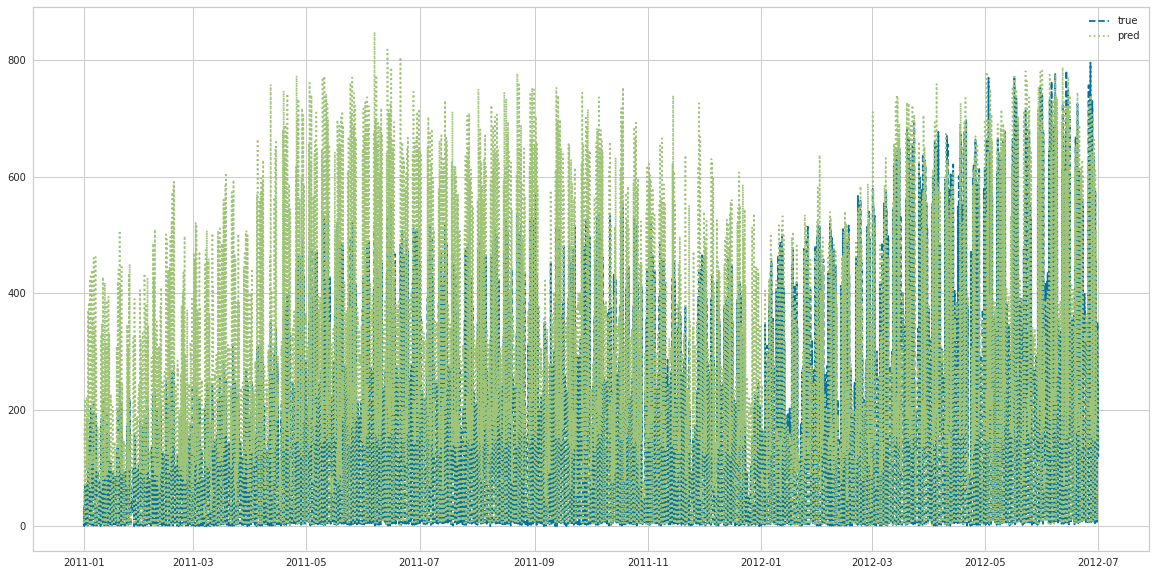

In [38]:
def ts_plot_trainset_true_pred(model, df_train):
    """横軸時系列でtrain setの正解と予測plot"""
    #pd.options.plotting.backend = "plotly"  # pandas plot をplotly化できなかった。。。

    df_pred = predict_model(model, data=df_train)
    # 対数化を戻す
    df_pred["Label"] = df_pred["Label"].apply(np.expm1)

    # 対数化を戻す
    df_train['count'] = df_train[_target].apply(np.expm1)
    #df_train['count_registered_ymdh_mean'] = df_train['count_registered_ymdh_mean'].apply(np.expm1)
    #df_train['count_casual_ymdh_mean'] = df_train['count_casual_ymdh_mean'].apply(np.expm1)    
    #df_train['count_month_mean'] = df_train['count_month_mean'].apply(np.expm1)
    #df_train['count_month_std'] = df_train['count_month_std'].apply(np.expm1)
    #df_train['count_shift'] = df_train['count_shift'].apply(np.expm1)

    df_pred['datetime'] = pd.to_datetime(df_pred['datetime'], format='%Y-%m-%d %H:%M:%S')  # datetime型に変換
    df_train['datetime'] = pd.to_datetime(df_train['datetime'], format='%Y-%m-%d %H:%M:%S')  # datetime型に変換

    # 正解と予測の結果csvも出す
    pd.concat([df_train, df_pred[["Label"]]], axis=1).to_csv(os.path.join(output_dir, 'train_pred.csv'), index=False)
    
    fig = plt.figure(figsize=(20, 10))
    #df_train.plot(x="datetime", y='count')
    #df_pred.plot(x="datetime", y='Label')
    plt.plot(df_train['datetime'], df_train['count'], linestyle='dashed', label='true')
    plt.plot(df_pred['datetime'], df_pred['Label'], linestyle='dotted', label='pred')
    #sns.lineplot(data=df_train, x="datetime", y='count', color='red', label='train', markers="-")
    #sns.lineplot(data=df_pred, x="datetime", y='Label', color='blue', label='pred_train')
    plt.legend() 
    plt.show()
    return 
    
loaded_model = load_model(os.path.join(output_dir, 'pycaret_stack_1'))
ts_plot_trainset_true_pred(loaded_model, df_train)

## submitファイル足し算

In [5]:
import os
import pathlib
import pandas as pd


def blend_submit_csv(csvs: list, ratios: list, output_dir: str):
        """submit.csvの目的変数をブレンドする（ratioを掛けて混ぜる）"""
        dfs = [pd.read_csv(c) for c in csvs]
        pred = None
        for r, df in zip(ratios, dfs):
            _p = r * df["cnt"]
            pred = _p if pred is None else pred + _p
        print(pred)
        submission = pd.DataFrame({"datetime": dfs[0]["datetime"], "cnt": pred})
        save_csv = os.path.join(output_dir, "blend_" + pathlib.Path(csvs[0]).stem + ".csv")
        submission.to_csv(save_csv, index=False)
        print(f"INFO: save csv: {save_csv}")
        print()
        
output_dir = "model/pycaret_regression"
for csv in ["tuned_catboost.csv", "tuned_lightgbm.csv", "stack_meta.csv", "stack_1.csv", "blend.csv"]:
    csv1 = output_dir + "/casual/" + csv
    csv2 = output_dir + "/registered/" + csv
    csvs = [csv1, csv2]
    ratios = [1.0, 1.0]
    blend_submit_csv(csvs, ratios, output_dir)

0       148.165203
1       111.633870
2        91.756704
3        34.480858
4        11.158380
           ...    
4371    253.411986
4372    170.546511
4373    126.710150
4374     83.027202
4375     46.472273
Name: cnt, Length: 4376, dtype: float64
INFO: save csv: model/pycaret_regression/blend_tuned_catboost.csv

0       141.576101
1       117.262628
2        94.277094
3        39.616452
4        12.196150
           ...    
4371    223.077905
4372    155.967953
4373    112.595136
4374     81.508840
4375     44.046658
Name: cnt, Length: 4376, dtype: float64
INFO: save csv: model/pycaret_regression/blend_tuned_lightgbm.csv

0       136.081353
1       110.801106
2        97.920720
3        43.229145
4        11.611003
           ...    
4371    275.146075
4372    176.030937
4373    127.062555
4374     90.457384
4375     43.925803
Name: cnt, Length: 4376, dtype: float64
INFO: save csv: model/pycaret_regression/blend_stack_meta.csv

0       157.658608
1       123.944064
2       101.127249